## House Prices : Adavanced Regression Techniques

- 성능 평가 방법 : RMSLE

### 1. 패키지 설치 및 데이터 로드

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

house_df_org = pd.read_csv(r'C:\Users\hanjieun_2\Desktop\개인공부\algorithms\1.ML\1.Supervised_Learning\2.Estimation\datasets\houseprice_train.csv')
# 가공을 많이 수행할 예정이므로 원본을 copy하여 복사
house_df = house_df_org.copy()
house_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [2]:
print('데이터 세트의 shape:',house_df.shape)
print('\n전체 피처의 type \n', house_df.dtypes.value_counts())
isnull_series = house_df.isna().sum()
print('\nNull 칼럼과 그 건수:\n', isnull_series[isnull_series>0].sort_values(ascending=False))

데이터 세트의 shape: (1460, 81)

전체 피처의 type 
 object     43
int64      35
float64     3
Name: count, dtype: int64

Null 칼럼과 그 건수:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


#### Target 값이 정규분포를 띄고 있는지 확인해보기

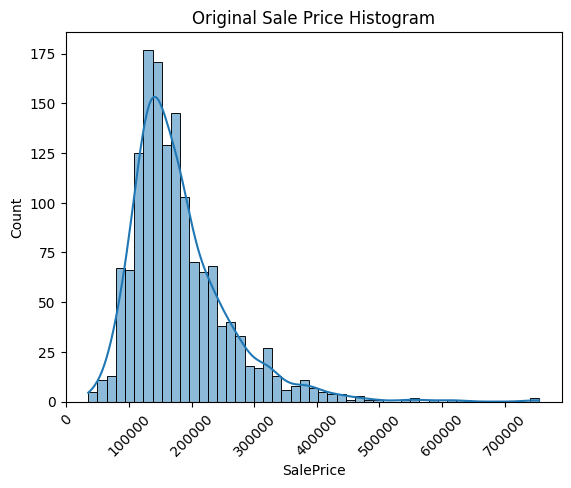

In [3]:
plt.title('Original Sale Price Histogram')
plt.xticks(rotation=45)
sb.histplot(house_df['SalePrice'], kde=True)
plt.show()

> 10000~20000 에 집중되어 분포되어있다. 따라서 정규분포를 띄게 하기 위해 `로그변환`이 필요하다.

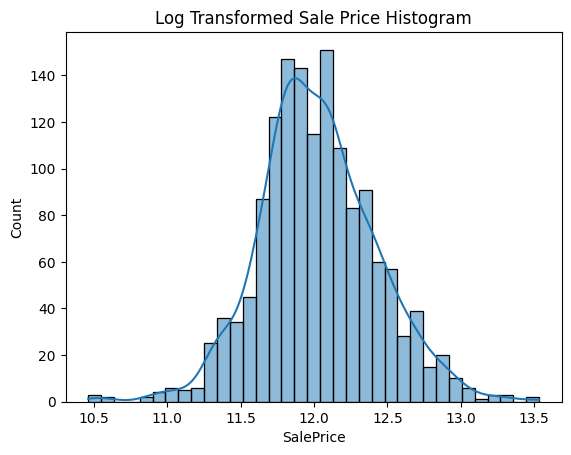

In [4]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sb.histplot(log_SalePrice, kde=True)
plt.show()

> 로그변환 이후 정규분포 형태로 결과값이 분포함을 확인

### 2. 전처리
- 종속변수 SalePrice : 로그변환
- 독립변수 int/float형 : null값 처리
- 독립변수 object형 : get_dummies 처리

In [5]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Null이 너무 많은 칼럼과 불필요한 칼럼 삭제
house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)

In [6]:
num_cols = house_df.select_dtypes(np.number).columns
num_cols

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [7]:
# 드롭하지 않는 숫자형 Null 칼럼은 평균값으로 대체
house_df[num_cols].fillna(house_df[num_cols].mean(), inplace=True)

# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type:\n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type:
 LotFrontage     float64
MasVnrType       object
MasVnrArea      float64
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Electrical       object
GarageType       object
GarageYrBlt     float64
GarageFinish     object
GarageQual       object
GarageCond       object
dtype: object


> 왜 float형은 평균값으로 fillna가 안되지..? 고로 다시 채워주기로 함.

In [8]:
house_df['LotFrontage'].fillna(house_df['LotFrontage'].mean(), inplace=True)
house_df['MasVnrArea'].fillna(house_df['MasVnrArea'].mean(), inplace=True)
house_df['GarageYrBlt'].fillna(house_df['GarageYrBlt'].mean(), inplace=True)

In [9]:
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type:\n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type:
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


> object형만 null값이 있다. -> object형은 원핫인코딩으로 변환!

In [10]:
print('get_dummies() 수행 전 데이터 shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 shape:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum()>0]
print('## Null 피처의 Type:\n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 shape: (1460, 75)
get_dummies() 수행 후 데이터 shape: (1460, 270)
## Null 피처의 Type:
 Series([], dtype: object)


### 3. 모델링 및 평가

#### 평가 함수 정의

In [11]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, '로그 변환된 RMSE:', np.round(rmse,3))
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

#### 모델링

##### **1. train_test_split 한 뒤 모델링 및 평가**

In [12]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg= LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.127
Lasso 로그 변환된 RMSE: 0.176


[0.13183184688250651, 0.12740582836266182, 0.17628250556471403]

##### 피처별 회귀 계수 확인해보기

In [13]:
def get_top_bottom_coef(model, n=10):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 칼럼명.
    coef = pd.Series(model.coef_, index=X_features.columns)

    # + 상위10개, - 하위 10개의 회귀계수를 추출해 반환.
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    
    return coef_high, coef_low

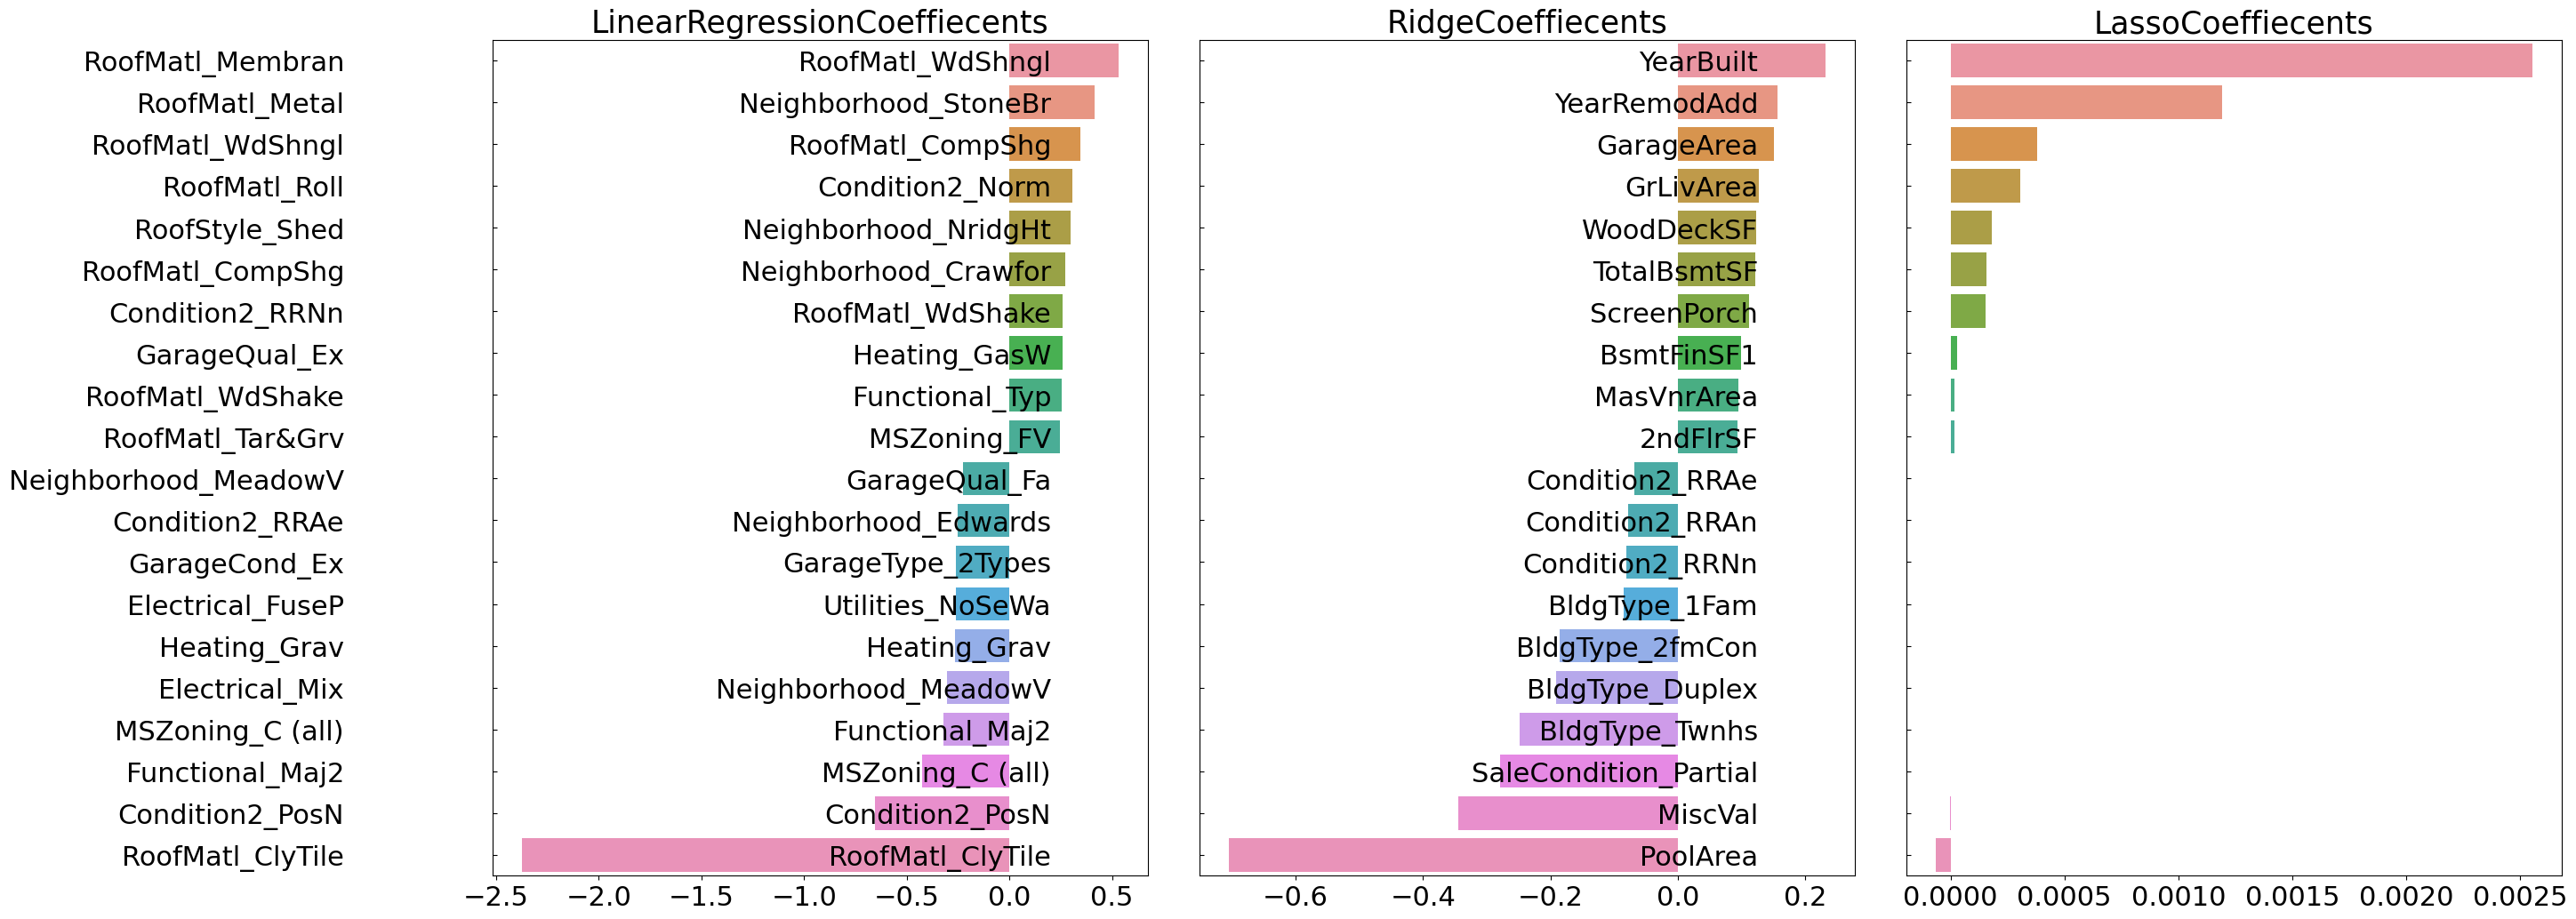

In [14]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 칼럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10), nrows=1, ncols=3)
    fig.tight_layout()

    # 입력 인자로 받은 list객체인 models에서 차례로 model을 추출해 회귀 계수 시각화.
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀계수를 구하고, 이를 판다스 concat으로 결합
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        # ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__ + 'Coeffiecents', size=25)
        axs[i_num].tick_params(axis='y', direction='in', pad=120)
        for label in (axs[i_num].get_xticklabels()+axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sb.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

> LinearRegression과 Ridge의 경우 회귀계수가 유사한 형태로 분포되어 있다. 하지만 Lasso는 전체적으로 회귀 계수 값이 매우 작고, 그와중에 YearBuilt가 가장 크고 다른 피처의 회귀계수는 너무 작다. 

> 학습 데이터의 데이터 분할 문제가 있을 수 있으므로, 학습과 테스트 데이터 세트를 train_test_split으로 나누지 않고 전체 데이터세트는 X_features와 y_target을 5개 교차 검증 폴드 세트로 분할해 평균 RMSE를 측정해보겠다. 이를 위해 cross_val_score를 이용

##### **2. train_test_split없이 전체 데이터에 대해 CV하여 모델링**

In [15]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score()수행. 모델별 CV RMSE 값 평균 RMSE 출력.
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target, scoring='neg_mean_squared_error', cv=5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트 : {1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format(model.__class__.__name__, np.round(rmse_avg,3)))

models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)              


LinearRegression CV RMSE 값 리스트 : [0.135 0.165 0.167 0.111 0.198]
LinearRegression CV 평균 RMSE 값: 0.155

Ridge CV RMSE 값 리스트 : [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값: 0.144

Lasso CV RMSE 값 리스트 : [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값: 0.198


> train_test_split없이 전체 X_features, y_target을 cv=5로 학습한 결과, 여전히 Lasso모델은 Linear, Ridge보다 성능이 떨어진다. 

> Ridge, Lasso에 alpha 파라미터에 변화를 주면서 최적값 도출해봐야겠다.

##### **3. Ridge, Lasso 모델은 alpha 값 변화주면서 최적값 도출**

In [16]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE값:{1}, 최적 alpha{2}'.format(model.__class__.__name__, 
                                                           np.round(rmse,4), grid_model.best_params_))
    
ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)


Ridge 5 CV 시 최적 평균 RMSE값:0.1418, 최적 alpha{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE값:0.142, 최적 alpha{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.124
Lasso 로그 변환된 RMSE: 0.12


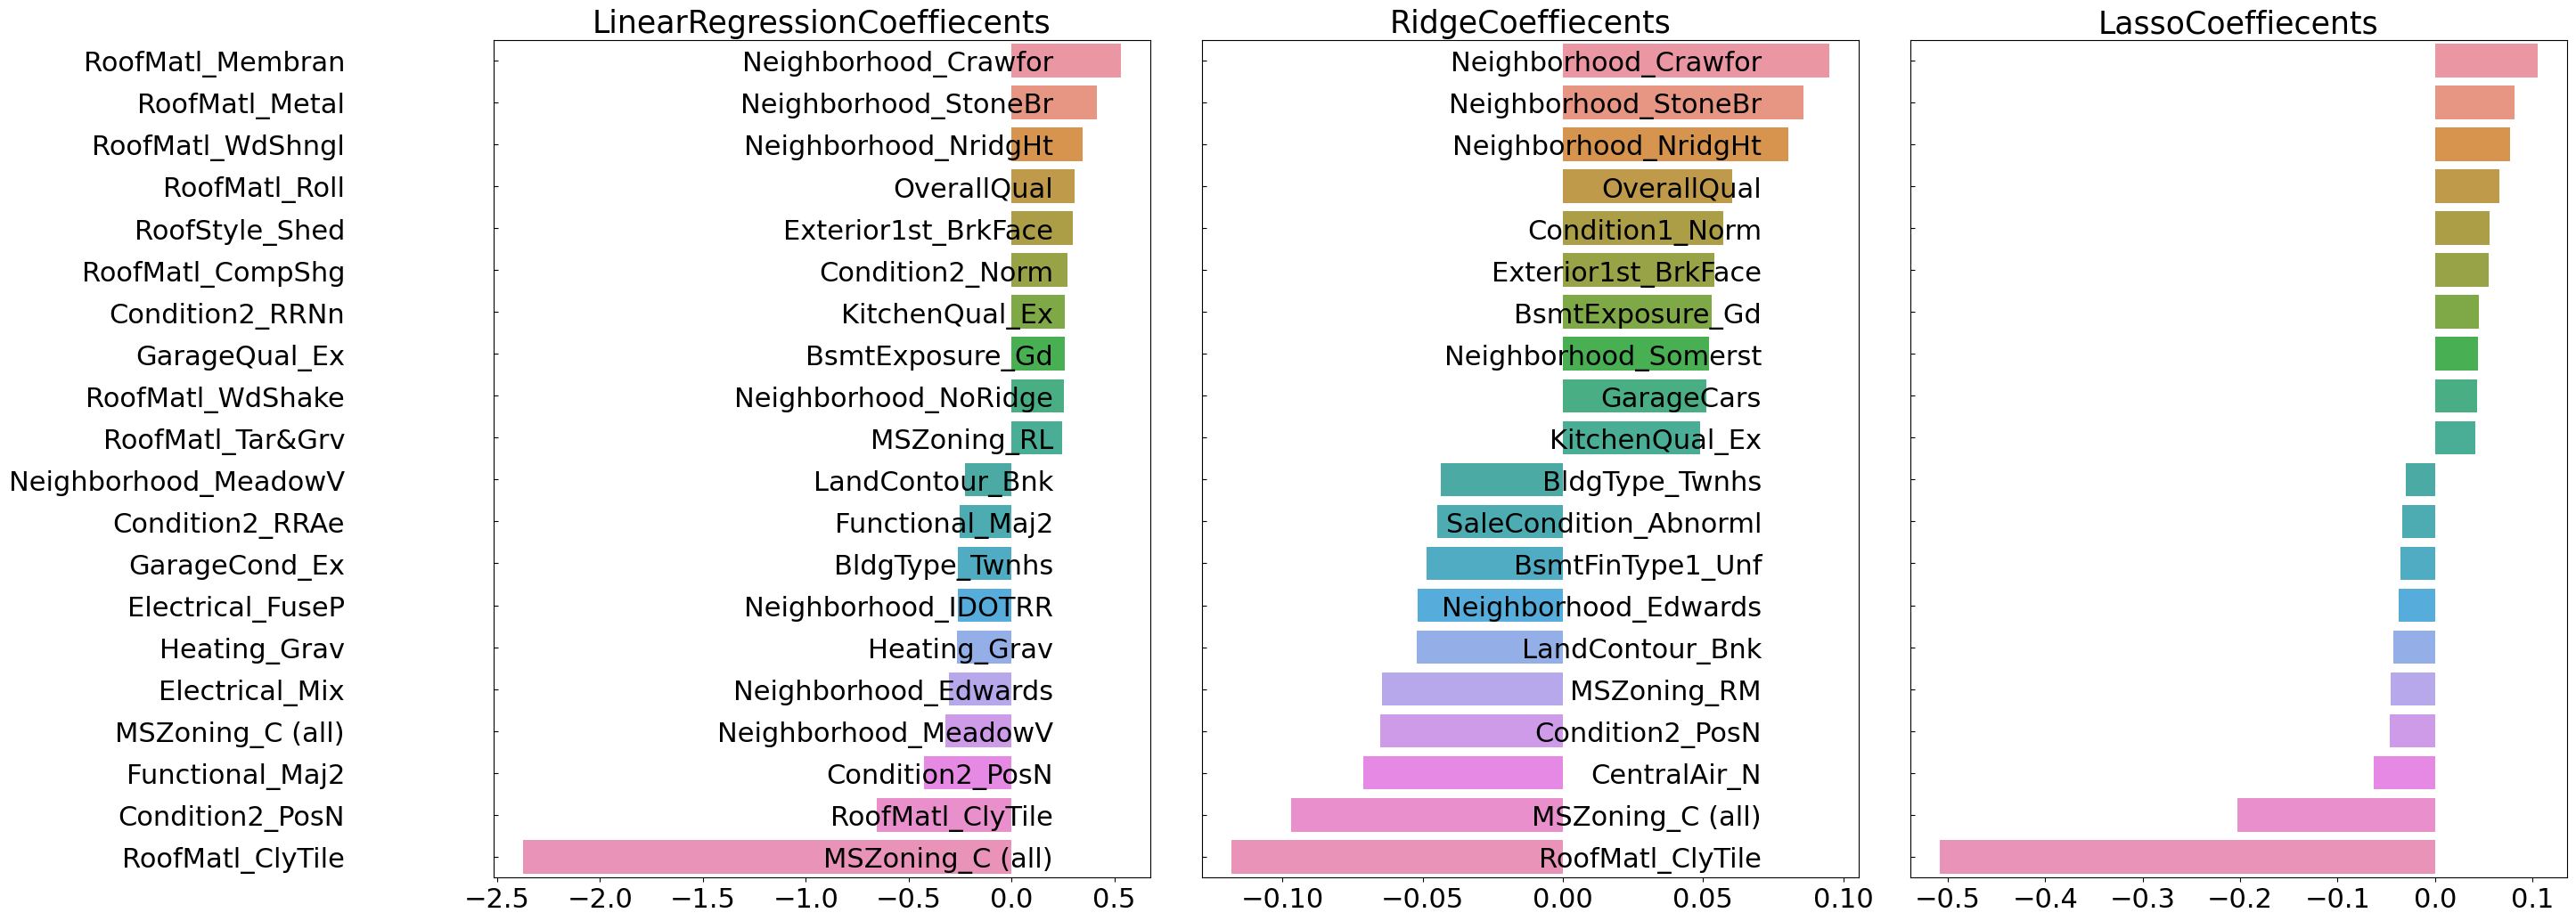

In [17]:
# 앞의 최적화 alpha 값 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행.
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

> alpha값 최적화 후 테스트 데이터 세트의 예측 성능이 향상되었다. 모델별 회귀계수도 많이 달라졌다. 기존에는 라쏘 모델의 회귀계수가 나머지 두 개 모델과 많은 차이가 있었지만, 이번에는 릿지와 라쏘 모델에서 비슷한 피처의 회귀계수가 높다. 다만 라쏘 모델의 경우에는 릿지에 비해 동일한 피처라도 회귀계수의 값이 상당히 작다. 

##### **5.테스트 데이터 분포도 확인과 이상치 데이터 처리**

##### 테스트 데이터의 분포도 확인하여 왜곡의 정도 확인해보기

- 종속변수 Target값의 분포도를 확인해보았었다. 이번엔 독립변수 피처들의 분포를 확인하여 지나치게 왜곡된 존재하고 있는지 확인해보겠다. 만약 지나치게 왜곡된 피처가 존재할 경우 회귀 예측 성능을 저하시킬 수 있다. 

- skew() 함수를 이용해 데이트 세트의 왜곡된 정도를 확인할 수 있다. 일반적으로 skew()함수의 반환값이 1이상인 경우를 왜곡 정도가 높다고 판단하지만 상황에 따라 편차는 있다. 
- __주의: skew()를 적용하는 숫자형 피처에서 원-핫 인코딩된 카테고리 숫자형 피처는 제외해야한다.__ 카테고리형 피처는 코드성 피처이므로 인코딩 시 당연히 왜곡될 가능성이 높다. 따라서 skew() 함수를 적용하는 DataFrame은 원-핫 인코딩이 적용된 house_df_ohe가 아니라 원-핫 인코딩이 적용되지 않은 house_df여야 한다. 

In [18]:
from scipy.stats import skew

# object가 아닌 숫자형 피처의 칼럼 index 객체 추출
features_index = house_df.dtypes[house_df.dtypes != 'object'].index

# house_df에 칼럼 index를 []로 입력하면 해당하는 칼럼 데이터 세트 반환. apply lambda로 skew() 호출
skew_features = house_df[features_index].apply(lambda x : skew(x))

# skew(왜곡) 정도가 1 이상인 칼럼만 추출.
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


> 왜곡의 정도가 1 초과값인 칼럼만 추출

In [19]:
# 로그변환
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [20]:
# 왜곡 정도가 높은 피처를 로그변환 했으므로 다시 원-핫 인코딩을 적용하고 피처/타킷 데이터 세트 생성.
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 피처를 로그 변환 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = {'alpha': [0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha':[0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)


Ridge 5 CV 시 최적 평균 RMSE값:0.1275, 최적 alpha{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE값:0.1252, 최적 alpha{'alpha': 0.001}


> Ridge모델의 경우 최적 alpha값이 12에서 10으로 변경됐고, 두 모델 모두 피처의 로그 변환 이전과 비교해 릿지의 경우 0.1418에서 0.1275로, 라쏘의 경우 0.142에서 0.1252로, 5폴드 교차 검등의 평균 RMSE값이 향상되었다. 

LinearRegression 로그 변환된 RMSE: 0.128
Ridge 로그 변환된 RMSE: 0.122
Lasso 로그 변환된 RMSE: 0.119


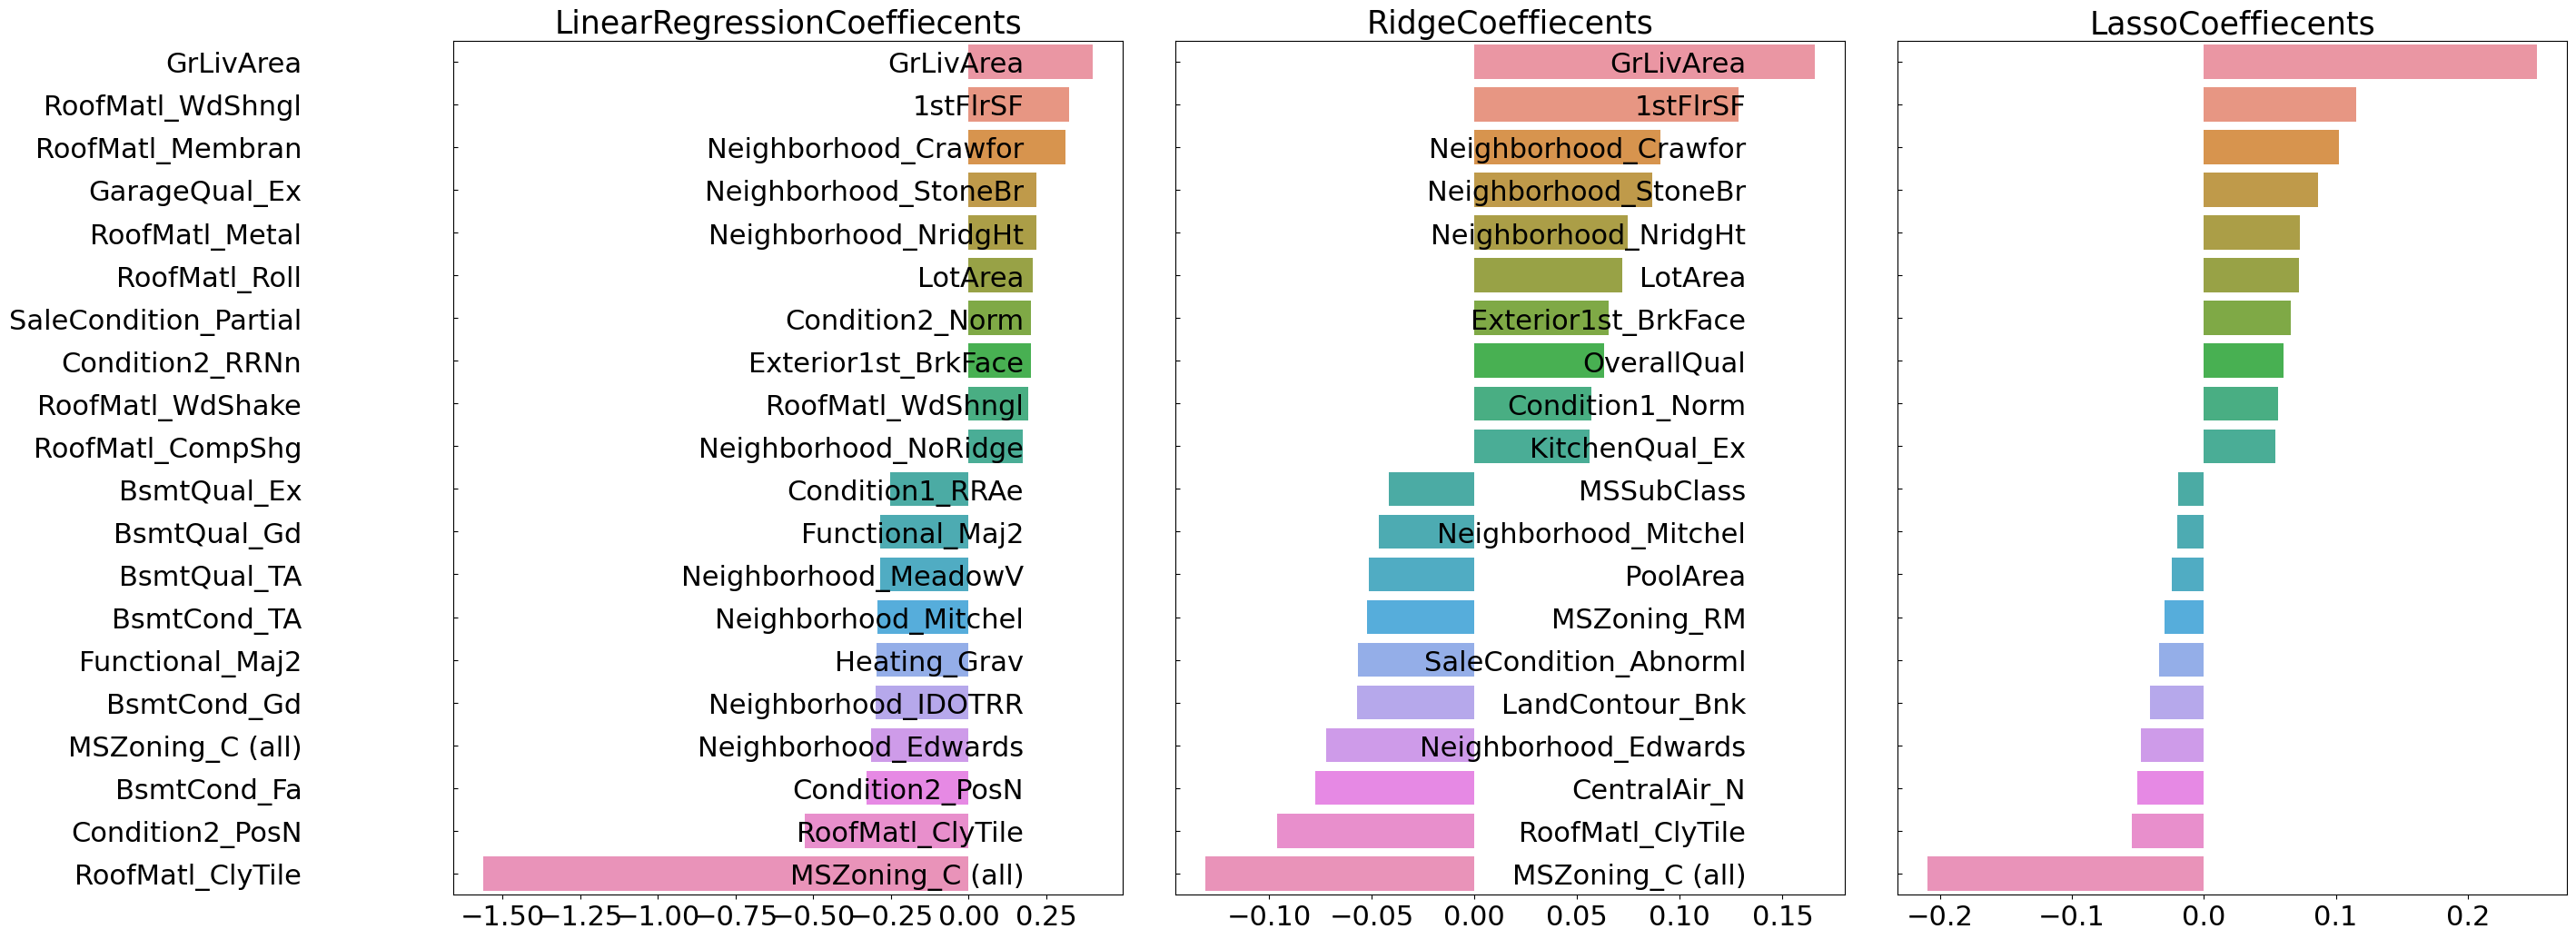

In [21]:
# 피처 로그변환 후(왜곡완화 후) + 최적 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행.
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

##### 이상치 데이터 살펴보기

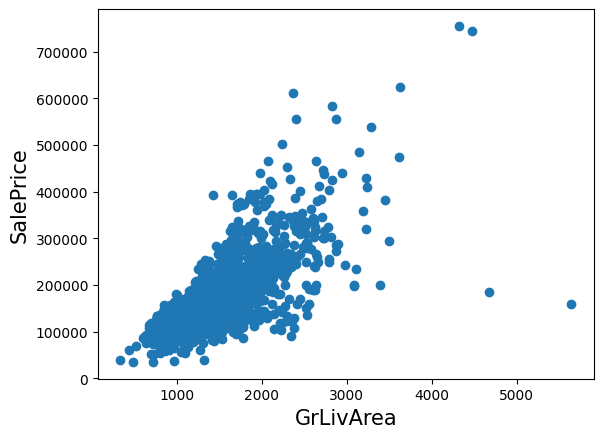

In [23]:
# 원본데이터 house_df_org 살펴보기
plt.scatter(x=house_df_org['GrLivArea'], y=house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

> 일반적으로 주거공간이 큰 집일수록 가격이 비싸기 떄문에 GrLivArea피처는 SalePrice와 양의 상관관계가 있따. 하지만 GrLivArea 4000~5000 2개의 데이터는 일반적인 관계에서 너무 어긋나있다. 이게 바로 outlier.

> GrLivArea가 4000평방피트 이상임에도 가격이 500,000달러 이하인 데이터는 모두 이상치로 간주하고 삭제하기로 함. 

In [24]:
# GrLivArea와 SalePrice 모두 로그 변환됐으므로 이를 반영한 조건 생성.
con1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
con2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[con1&con2].index

print('이상치 레코트 index:', outlier_index.values)
print('이상치 삭제 전 house_df_ohe shape:', house_df_ohe.shape)

# DataFrame의 인덱스를 이용해 이상치 레코트 삭제
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 house_df_ohe_shape:', house_df_ohe.shape)

이상치 레코트 index: [ 523 1298]
이상치 삭제 전 house_df_ohe shape: (1460, 270)
이상치 삭제 후 house_df_ohe_shape: (1458, 270)


In [25]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE값:0.1125, 최적 alpha{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE값:0.1122, 최적 alpha{'alpha': 0.001}


> 단 두개의 이상치 데이터만 제거했는데, 예측 수치가 매우 크게 향상되었다. 그리고 릿지모델의 경우 최적 alpha값은 10에서 8로, 평균 RMSE가 0.1275에서 0.1125로 개선되었다. 라쏘 모델의 경우는 평균 RMSE가 0.1252에서 0.1122로 개선되었다. 

In [26]:
# 이상치 데이터 제거 이후, 모델링 및 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
print('LinearRegression 로그 변환된 RMSE:', np.round(rmse,4))

ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
pred = ridge_reg.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
print('ridge 로그 변환된 RMSE:', np.round(rmse,4))

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
pred = lasso_reg.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
print('Lasso 로그 변환된 RMSE:', np.round(rmse,4))

LinearRegression 로그 변환된 RMSE: 0.1287
ridge 로그 변환된 RMSE: 0.1034
Lasso 로그 변환된 RMSE: 0.1002


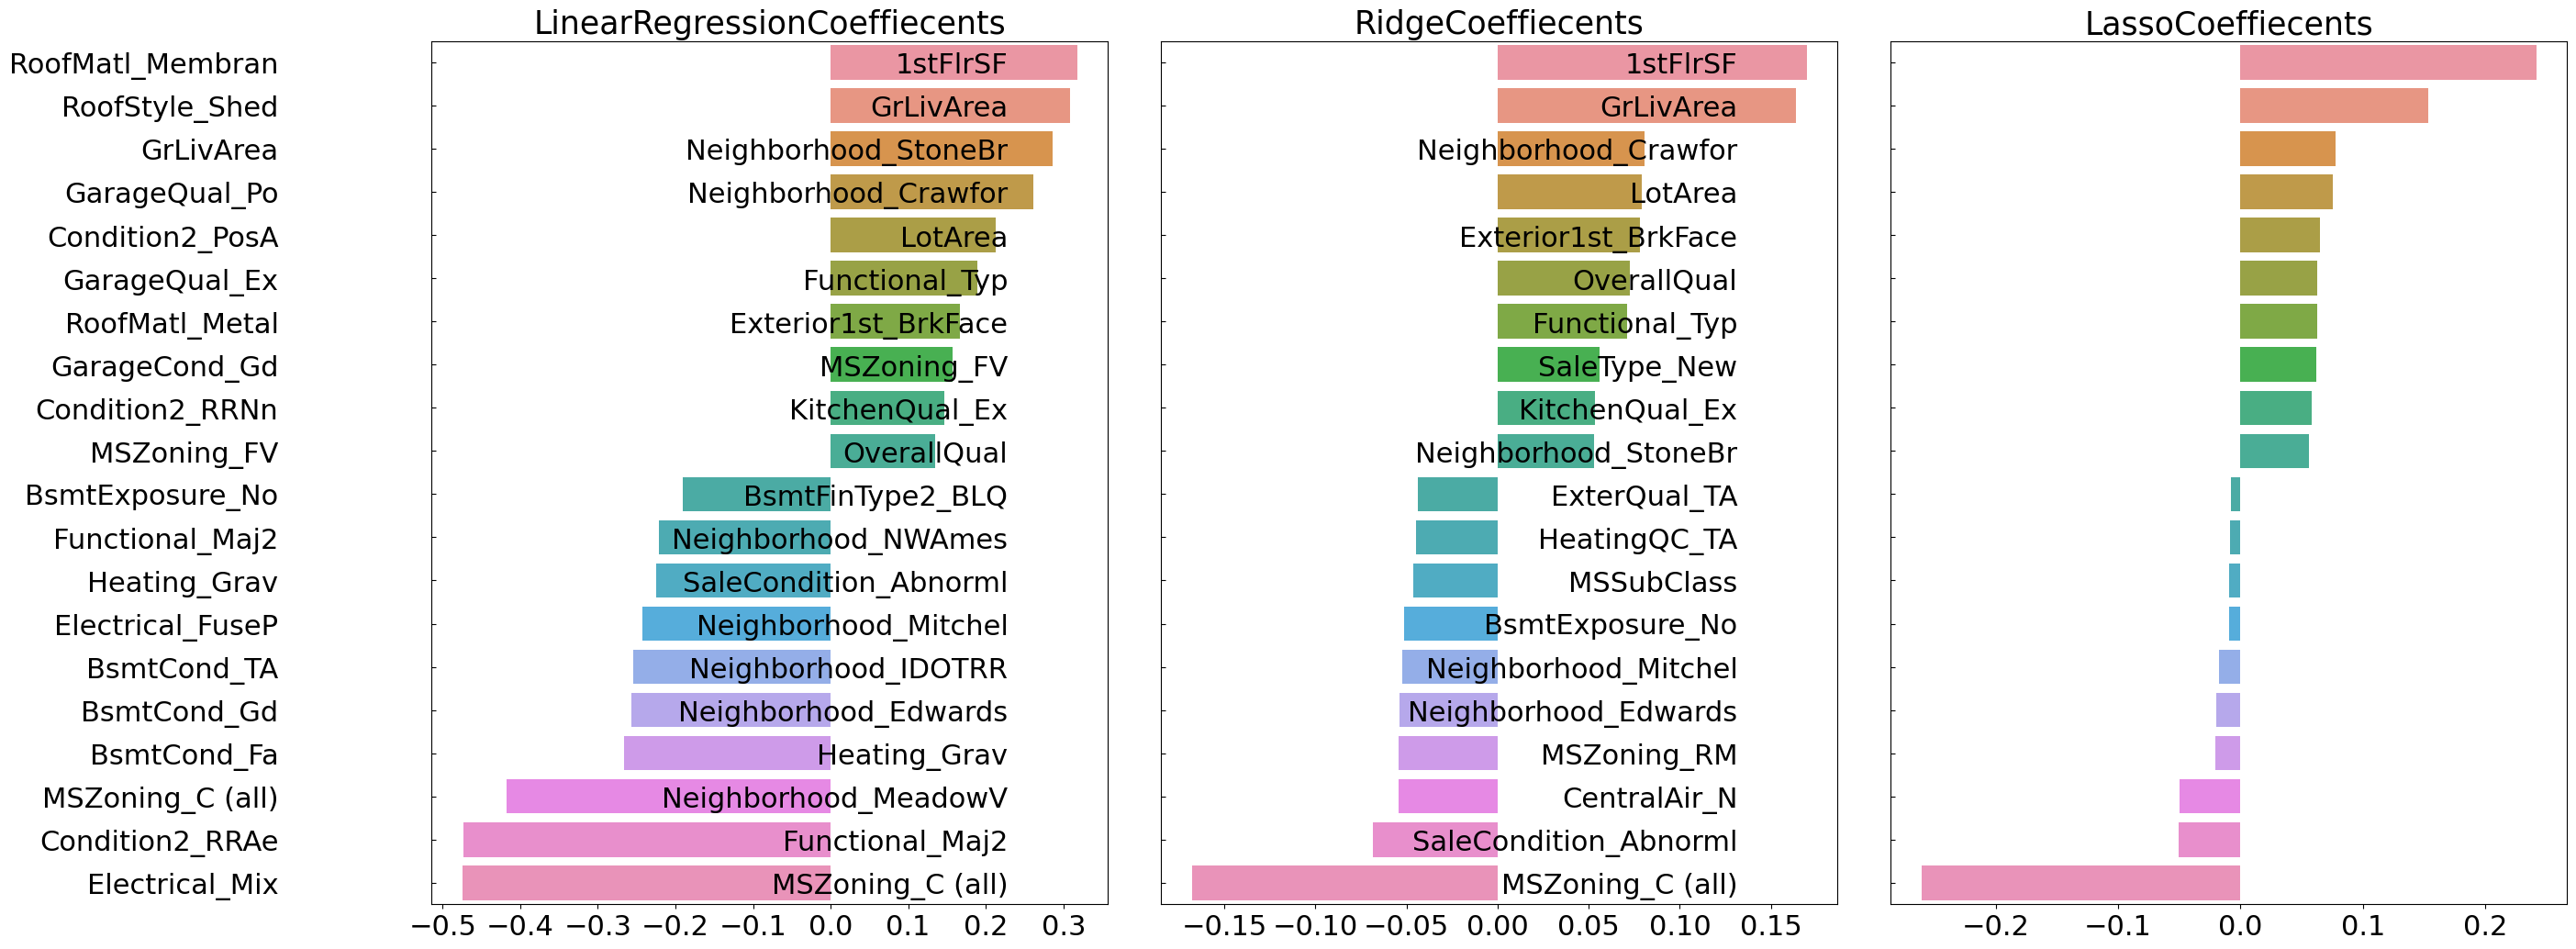

In [27]:
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

*************
### 회귀트리 모델 학습/예측/평가

In [28]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators': [1000]}

xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)


grid_model = GridSearchCV(xgb_reg, param_grid=xgb_params, scoring='neg_mean_squared_error', cv=5)
grid_model.fit(X_train, y_train)
pred = grid_model.predict(X_test)
rmse = np.sqrt(-1*grid_model.best_score_)
print('{0} 5 CV 시 최적 평균 RMSE값:{1}, 최적 alpha{2}'.format(XGBRegressor, 
                                                           np.round(rmse,4), grid_model.best_params_))


<class 'xgboost.sklearn.XGBRegressor'> 5 CV 시 최적 평균 RMSE값:0.1267, 최적 alpha{'n_estimators': 1000}


<Axes: >

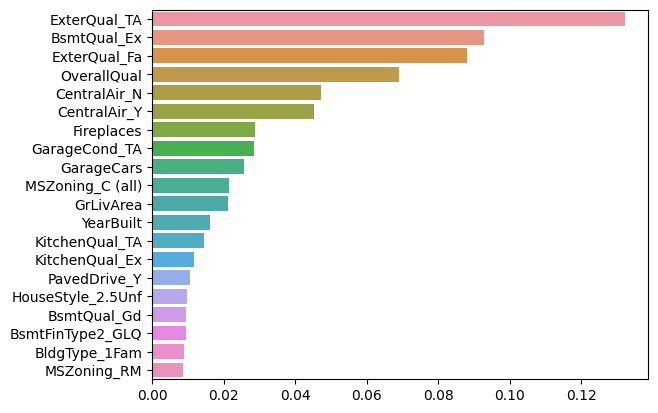

In [46]:
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
xgb.fit(X_train, y_train)
gred = xgb.predict(X_test)

# print(xgb.feature_importances_)

features_series = pd.Series(data=xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
sb.barplot(x=features_series[:20], y=features_series.index[:20])


In [31]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}

lgb_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                        subsample=0.6, colsample=0.4, reg_lambda=10, n_jobs=-1)

grid_model = GridSearchCV(lgb_reg, param_grid=lgbm_params, scoring='neg_mean_squared_error', cv=5)
grid_model.fit(X_train, y_train)
pred = grid_model.predict(X_test)
print('{0} 5 CV 시 최적 평균 RMSE값:{1}, 최적 alpha{2}'.format(grid_model.__class__.__name__, 
                                                       np.round(np.sqrt(-1*grid_model.best_score_),4),
                                                       grid_model.best_params_))

[LightGBM] [Warning] Unknown parameter: colsample
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: colsample
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2924
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 156
[LightGBM] [Info] Start training from score 12.035561
[LightGBM] [Warning] Unknown parameter: colsample
[LightGBM] [Warning] Unknown parameter: colsample
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: colsample
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Tota

[LightGBM] [Warning] Unknown parameter: colsample
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: colsample
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3174
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 172
[LightGBM] [Info] Start training from score 12.025343
[LightGBM] [Warning] Unknown parameter: colsample


<Axes: >

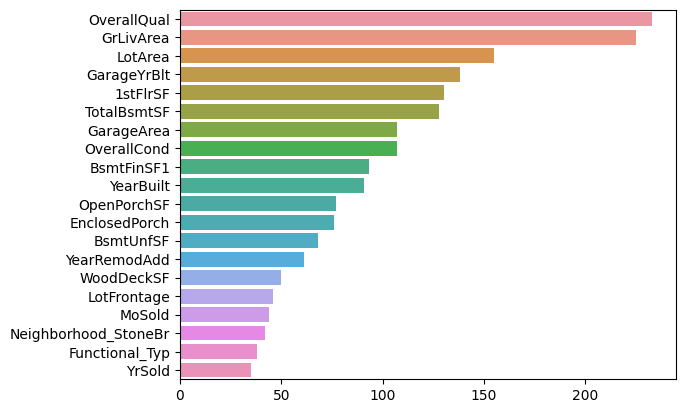

In [47]:
lgb = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                        subsample=0.6, colsample=0.4, reg_lambda=10, n_jobs=-1)

lgb.fit(X_train, y_train)
pred = lgb.predict(X_test)

features_series = pd.Series(data=lgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
sb.barplot(x=features_series[:20], y=features_series.index[:20])

### 회귀모델의 예측 결과 혼합을 통한 최종 예측

만약 A모델과 B모델, 두 모델의 예측값이 있다면 A모델 예측값의 40%, B모델 예측값의 60%를 더해서 최종 회귀 값으로 예측하는 것이다. 

In [54]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test, pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE:{1}'.format(key, rmse))

In [55]:
# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 개별 모델의 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종혼합':pred, 
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}

# 최종 혼합 모델, 개별모델의 RMSE값 출력
get_rmse_pred(preds)

최종혼합 모델의 RMSE:0.10006075517615189
Ridge 모델의 RMSE:0.10340697165289335
Lasso 모델의 RMSE:0.10024171179335334


> 최종혼합모델의 RMSE가 개별모델보다 성능 면에서 개선되었다. 0.4나 0.6을 정하는 특별한 기준은 없다. 두 개 중 성능이 조금 좋은 쪽에 가중치를 두었다.

In [56]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
lgb_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,
                        subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)

xgb_reg.fit(X_train, y_train)
lgb_reg.fit(X_train, y_train)

xgb_pred = xgb_reg.predict(X_test)
lgb_pred = lgb_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgb_pred

preds = {'최종혼합':pred, 
         'XGBM':xgb_pred, 
         'LGBM':lgb_pred}

get_rmse_pred(preds)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3174
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 172
[LightGBM] [Info] Start training from score 12.025343
최종혼합 모델의 RMSE:0.1014930603755743
XGBM 모델의 RMSE:0.10608167218368826
LGBM 모델의 RMSE:0.10363891833477148


> XGBoost와 LightGBM의 혼합모델의 RMSE가 개별 모델의 RMSE보다 조금 향상되었다.